### Car statistics

File for doing some statistical tests on data from cars. We'll look at whether the fuel efficiency, in miles per gallon (mpg) or watt-hours per kilometer (Wh/km), is different depending on fuel type, i.e. between cars running on gas or batteries. The cars and their efficiency are available from two different datasets.

Additionally, we look at the efficiency of different classes and makes of gas cars.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
data_gas = pd.read_csv('../data/cars_data/car_data.csv')
data_gas.head()

,city_mpg,class,combination_mpg,cylinders,displacement,drive,fuel_type,highway_mpg,make,model,transmission,year
0,25,midsize car,29,4.0,2.5,fwd,gas,36,mazda,6,m,2014
1,26,midsize car,30,4.0,2.5,fwd,gas,37,mazda,6,a,2014
2,25,small sport utility vehicle,27,4.0,2.5,fwd,gas,31,mazda,cx-5 2wd,a,2014
3,26,small sport utility vehicle,29,4.0,2.0,fwd,gas,34,mazda,cx-5 2wd,m,2014
4,26,small sport utility vehicle,28,4.0,2.0,fwd,gas,32,mazda,cx-5 2wd,a,2014


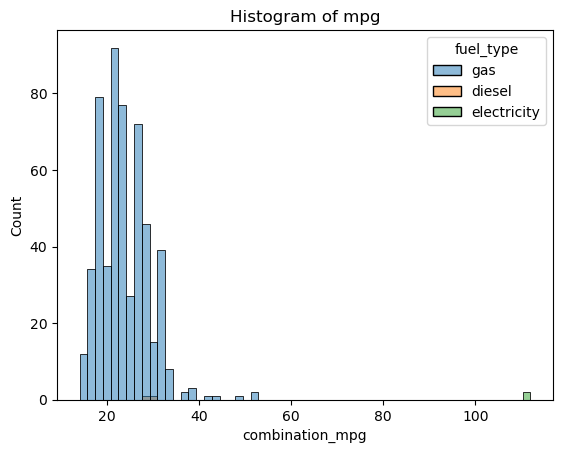

In [3]:
plt.figure()
sns.histplot(data=data_gas, x='combination_mpg', hue='fuel_type')
plt.title('Histogram of mpg')
plt.show()

In [4]:
# Count how many of each fuel type there are
fuel_counts = data_gas['fuel_type'].value_counts()
print(fuel_counts)

# As there are basically only gas cars here, we just use those
data_gas = data_gas[data_gas['fuel_type'] == 'gas']
# There are different mpg's in the data, of which we use the combination one for the analysis
mpg_gas = data_gas['combination_mpg'].rename('mpg')

fuel_type
gas            546
diesel           2
electricity      2
Name: count, dtype: int64


In [5]:
data_EV = pd.read_csv('../data/cars_data/EV_cars.csv')
data_EV.head()

,Battery,Car_name,Car_name_link,Efficiency,Fast_charge,Price.DE.,Range,Top_speed,acceleration..0.100.
0,75.0,Tesla Model Y Long Range Dual Motor,https://ev-database.org/car/1619/Tesla-Model-Y...,172,670.0,59017.0,435,217,5.0
1,57.5,Tesla Model 3,https://ev-database.org/car/1991/Tesla-Model-3,137,700.0,46220.0,420,201,6.1
2,60.5,BYD ATTO 3,https://ev-database.org/car/1782/BYD-ATTO-3,183,370.0,44625.0,330,160,7.3
3,61.7,MG MG4 Electric 64 kWh,https://ev-database.org/car/1708/MG-MG4-Electr...,171,630.0,39990.0,360,160,7.9
4,75.0,Tesla Model 3 Long Range Dual Motor,https://ev-database.org/car/1992/Tesla-Model-3...,149,780.0,55220.0,505,201,4.4


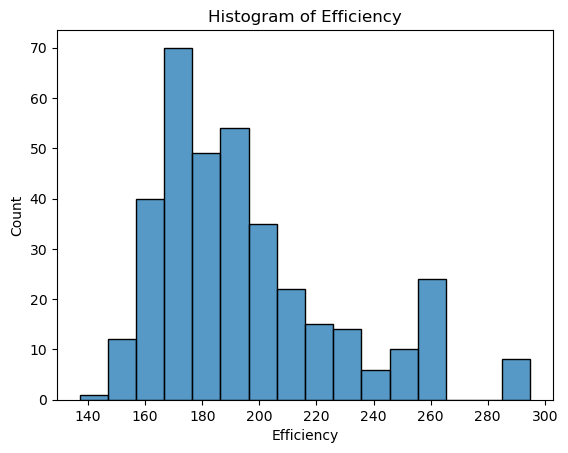

In [6]:
plt.figure()
sns.histplot(data=data_EV, x='Efficiency')
plt.title('Histogram of Efficiency')
plt.show()

In [7]:
data_EV_eff = data_EV['Efficiency']
print(data_EV_eff.head())
# Efficiency is in Wh/km, so we need to convert it to mpg. Use that 1 Wh = 3600 J, 1 km = 0.621 miles and 1 gallon of gas has about 120 MJ
mpg_EV = data_EV_eff.apply(lambda x: 1/x / 3600 * (120e6) * 0.621).rename('mpg')
print(mpg_EV.head())

0    172
1    137
2    183
3    171
4    149
Name: Efficiency, dtype: int64
0    120.348837
1    151.094891
2    113.114754
3    121.052632
4    138.926174
Name: mpg, dtype: float64


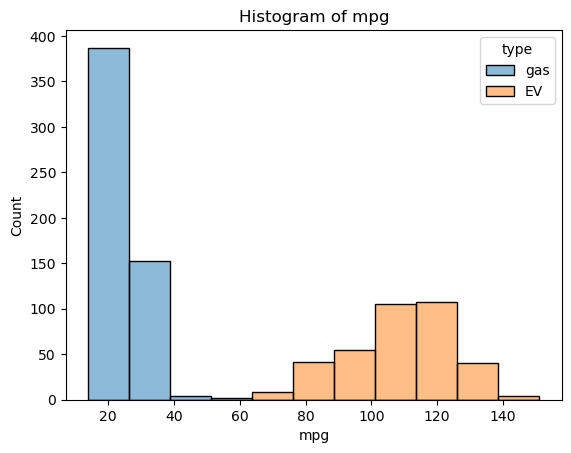

In [8]:
# Add the type of car to the data
gas_df = pd.DataFrame({'mpg': mpg_gas, 'type': 'gas'})
EV_df = pd.DataFrame({'mpg': mpg_EV, 'type': 'EV'})
combined_df = pd.concat([gas_df, EV_df])

plt.figure()
sns.histplot(data=combined_df, x='mpg', hue='type')
plt.title('Histogram of mpg')
plt.show()

This is quite clearly a win for the batteries, without requiring a test. 

But let's do it anyway. Due to the large sample size (>~30), we can do a z-test and don't need a t-test.

In [9]:
mean_mpg_gas = mpg_gas.mean()
std_mpg_gas = mpg_gas.std(ddof=1)
mean_mpg_EV = mpg_EV.mean()
std_mpg_EV = mpg_EV.std(ddof=1)

diff = mean_mpg_gas - mean_mpg_EV
size_gas, size_EV = len(mpg_gas), len(mpg_EV)
z_score = diff / np.sqrt(std_mpg_gas**2/size_gas + std_mpg_EV**2/size_EV)  # assuming there is no difference as null hypothesis
print(f'The z-score is {z_score:.2f}')
p_value = 2 * (1 - norm.cdf(abs(z_score), loc=0, scale=1))
print(f'The p-value is {p_value}')

p_value_left = norm.cdf(abs(z_score), loc=0, scale=1)
p_value_right = 1 - p_value_left
print(f'The p-value for the left tail is {p_value_left} and for the right tail is {p_value_right}')

The z-score is -97.88
The p-value is 0.0
The p-value for the left tail is 1.0 and for the right tail is 0.0


In [10]:
# Also do a t-test for fun
t_stat, p_value_t = ttest_ind(mpg_gas, mpg_EV, equal_var=False)
print(f'The t-statistic is {t_stat:.2f} and the p-value is {p_value_t}')

The t-statistic is -97.88 and the p-value is 3.842251499339041e-287


We indeed get the same result from the z- and t-test.  So we can also say with high statistical certainty that the mean efficiency for EV cars is different from, and even specifically larger than, the mean for gas cars.

### What about the cost per km?

In [11]:
# Use that the gas price is €7.442 per US gallon in the Netherlands (at time of writing) and
# the electricity price is €0.274 per kWh in the Netherlands (at time of writing)
price_EV_per_km = data_EV_eff.apply(lambda x: x / 1000 * 0.274)  # from Wh/km to €/km
price_gas_per_km = data_gas['combination_mpg'].apply(lambda x: 1/x * 0.621 * 7.442)  # from mpg to €/km

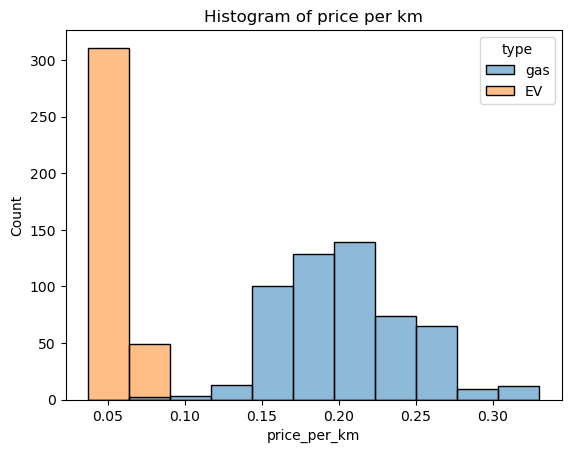

In [12]:
price_EV_df = pd.DataFrame({'price_per_km': price_EV_per_km, 'type': 'EV'})
price_gas_df = pd.DataFrame({'price_per_km': price_gas_per_km, 'type': 'gas'})
combined_price_df = pd.concat([price_gas_df, price_EV_df])

plt.figure()
sns.histplot(data=combined_price_df, x='price_per_km', hue='type')
plt.title('Histogram of price per km')
plt.show()

In [13]:
mean_price_gas = price_gas_per_km.mean()
std_price_gas = price_gas_per_km.std()
mean_price_EV = price_EV_per_km.mean()
std_price_EV = price_EV_per_km.std()

diff_price = mean_price_gas - mean_price_EV
z_score_price = diff_price / np.sqrt( std_price_gas**2/size_gas + std_price_EV**2/size_EV )  # assuming there is no difference as null hypothesis
print(f'The z-score is {z_score_price:.2f}')
p_value_price = 2 * (1 - norm.cdf(abs(z_score_price), loc=0, scale=1))
print(f'The p-value is {p_value_price}')

p_value_left_price = norm.cdf(abs(z_score_price), loc=0, scale=1)
p_value_right_price = 1 - p_value_left_price
print(f'The p-value for the left tail is {p_value_left_price} and for the right tail is {p_value_right_price}')

The z-score is 79.68
The p-value is 0.0
The p-value for the left tail is 1.0 and for the right tail is 0.0


So the batteries are significantly cheaper, as well.

### Next look at mpg per car class

for gas cars only. Then we need a one-way ANOVA test.

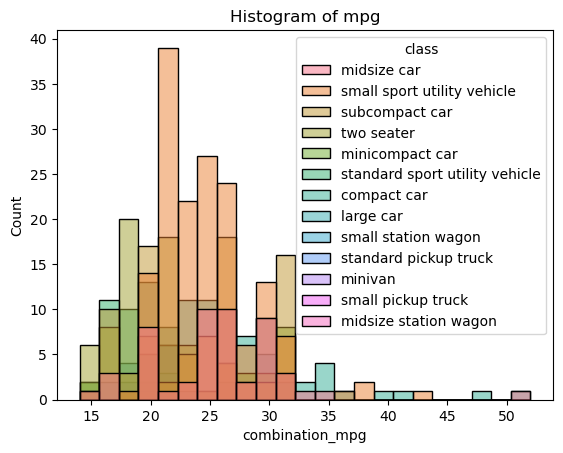

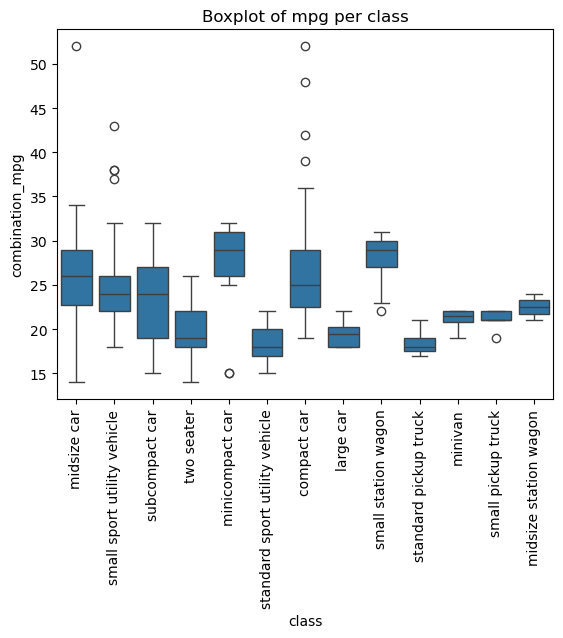

In [14]:
# Plot mpg for each car class
plt.figure()
sns.histplot(data=data_gas, x='combination_mpg', hue='class')
plt.title('Histogram of mpg')
plt.show()

# Box plots
plt.figure()
sns.boxplot(data=data_gas, x='class', y='combination_mpg')
plt.title('Boxplot of mpg per class')
plt.xticks(rotation=90)
plt.show()

In [15]:
# Get mpg for each class
classes = [x for x in data_gas['class'].unique() if data_gas['class'].value_counts()[x] > 20]  # do need enough data
mpg_classes = {class_: data_gas[data_gas['class'] == class_]['combination_mpg'] for class_ in classes}

# ANOVA test
f_stat, p_value_f = f_oneway(*mpg_classes.values())
print(f'The F-statistic is {f_stat:.2f} and the p-value is {p_value_f}')

The F-statistic is 27.47 and the p-value is 2.6472974395991093e-28


So at least one of these is different from the others.

Figure out which ones differ:

In [16]:
mpg_classes_df = data_gas[['combination_mpg', 'class']]
mpg_classes_df = mpg_classes_df[mpg_classes_df['class'].isin(classes)]
# Rename class to car_class, because otherwise ols below will not work for some reason
mpg_classes_df = mpg_classes_df.rename(columns={'class': 'car_class'})

model = ols('combination_mpg ~ C(car_class)', data=mpg_classes_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Perform Tukey's HSD test, with 0.05 significance level
tukey_result = pairwise_tukeyhsd(mpg_classes_df['combination_mpg'], mpg_classes_df['car_class'], alpha=0.05)
print(tukey_result)

                    sum_sq     df          F        PR(>F)
C(car_class)   3575.037688    6.0  27.474773  2.647297e-28
Residual      10669.900187  492.0        NaN           NaN
                         Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
            group1                         group2             meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------------------------------------------
                   compact car                    midsize car  -0.8401 0.9493  -3.2785  1.5983  False
                   compact car                minicompact car   1.3155 0.9098  -2.0522  4.6833  False
                   compact car    small sport utility vehicle  -1.9589 0.0333    -3.83 -0.0879   True
                   compact car standard sport utility vehicle  -8.3175    0.0 -11.1248 -5.5102   True
                   compact car                 subcompact car   -2.506 0.0102  -4.6462 -0.3658   True
       

Then we see that e.g. compact and midsize car are not significantly different, while e.g. compact and subcompact car are, as indicated by the 'reject' column.

Now how about the dependence on both car class and make? For this we need a two-way ANOVA test.

In [22]:
# First check different car makes
#print(data_gas['make'].value_counts())
# To keep the number of comparisons down, we only look at over 30 makes and classes
makes = [x for x in data_gas['make'].unique() if data_gas['make'].value_counts()[x] > 30]
classes = [x for x in data_gas['class'].unique() if data_gas['class'].value_counts()[x] > 30]
mpg_makes_classes_df = data_gas[['combination_mpg', 'make', 'class']]
mpg_makes_classes_df = mpg_makes_classes_df[mpg_makes_classes_df['make'].isin(makes) & mpg_makes_classes_df['class'].isin(classes)]
# Rename again
mpg_makes_classes_df = mpg_makes_classes_df.rename(columns={'class': 'car_class'})

model = ols('combination_mpg ~ C(make) + C(car_class)', data=mpg_makes_classes_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
print()

# Perform Tukey's HSD test, with 0.05 significance level
# Create a new column for the interaction of class and make
mpg_makes_classes_df['class_make'] = mpg_makes_classes_df['car_class'] + '_' + mpg_makes_classes_df['make']
tukey_result = pairwise_tukeyhsd(mpg_makes_classes_df['combination_mpg'], mpg_makes_classes_df['class_make'], alpha=0.05)
print(tukey_result)

                   sum_sq     df          F        PR(>F)
C(make)       1653.968970    4.0  32.210529  1.229437e-21
C(car_class)   404.491838    5.0   6.301882  1.581460e-05
Residual      3196.456908  249.0        NaN           NaN

                                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                                 
                group1                                 group2                 meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------------------------------------------------------
                       compact car_bmw                    compact car_hyundai   5.4386 0.0036   0.9705  9.9067   True
                       compact car_bmw                     compact car_jaguar   3.1053 0.9647  -3.5607  9.7713  False
                       compact car_bmw                        midsize car_bmw  -2.6447 0.7946  -7.1128  1.8233  False
                       compact car_bmw                    m

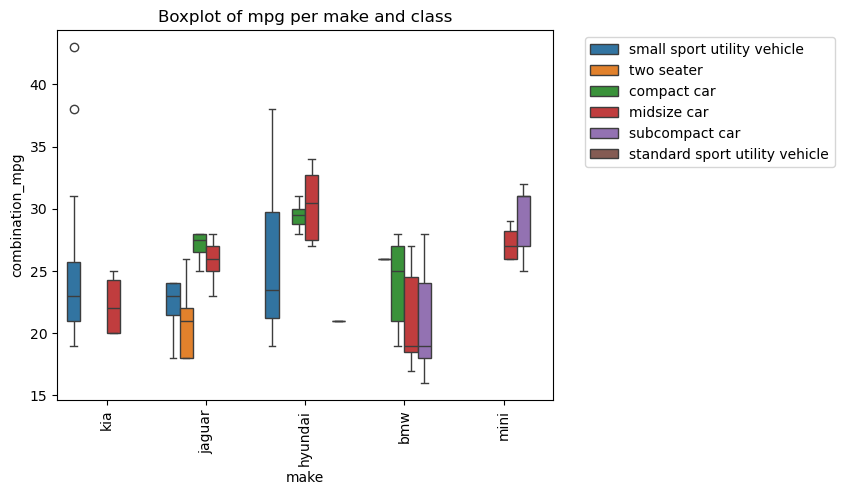

In [26]:
# Box plots to check
plt.figure()
sns.boxplot(data=mpg_makes_classes_df, x='make', y='combination_mpg', hue='car_class')
plt.title('Boxplot of mpg per make and class')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

So e.g. compact car + bmw and compact car + hyundai are significantly different which seems reasonable as they only slightly overlap between one's maximum and the other's minimum in the boxplot. And e.g. compact car + bmw and compact car + jaguar are not different, and we can see these indeed overlap more in the plot, so that seems good too.

Also, it seems like there are too few combinations of certain cars as well, so the statistics on those are likely not that good.